# HMM for Music and Speech Audio Classification

Using Hidden Markov Model to classify music and speech audio files.

Libraries used:
1) Numpy - for numerical computations such as fft(), dot operator
2) Scipy - to read the .wav file and find the likelihood of data points
3) Matplotlib - to plot the spectogram

## Frame Subsampling is NOT used
All the 2998 frames in each audio file is used as an observation.

In [1]:
import numpy as np

from scipy.io import wavfile
from scipy import signal

import matplotlib.pyplot as plt
import os
import random
import copy

### Question 3) a)

### Function read_audio()

Reads the .wav file and returns the sample_rate and the wav_file.

In [2]:
def read_audio(folder, input):
    sample_rate, wav_file = wavfile.read('speech_music_classification/'+folder+input)
    
    #print("Sample rate", sample_rate)
    
    length = len(wav_file)
    
    #print(length, wav_file)
    
    time_frame = length / sample_rate
    
    #To plot the audio wave
    #time = [i/sample_rate for i in range(len(wav_file))]
    #plt.plot(time, wav_file)
    #plt.show()
    
    return sample_rate, wav_file

### Function fft()

<strong> Window size </strong> = 25 ms = 25 / 1000 * 16000 = 400 samples

<strong> Shift </strong> = 10 ms = 10 / 1000 * 16000 = 160 samples

##### For each window, computes 64 point magnitude FFT and retains the first 32 dimensions in each window, apply log of the magnitude of the FFT.

##### Returns the spectogram of dimension 32 x 2998.

In [3]:
def fft(sample_rate, wav_file):
    length = len(wav_file)
    
    start = 0
    window_size = 25 * sample_rate // 1000

    shift = 10 * sample_rate // 1000
    
    #print("Windows size", window_size)
    #print("Shift", shift)

    i = 0
    while start + window_size <= length:    
        fft = np.abs(np.fft.fft(wav_file[start:start+window_size], axis= 0 , n=64)[:32])
        with np.errstate(divide='ignore'):
            fft = np.log(fft)
        fft[np.isneginf(fft)]=0
        
        if start == 0:
            spectogram = fft
        else:
            spectogram = np.vstack((spectogram, fft))

        start += shift
        i+=1
    
    return spectogram

### Function get_input_vector()

Reads the audio files in train dataset and performs fft on it to get the respective spectogram. 

#### Returns the spectogram of all audio files in the given folder as a combined input vector. 

In [4]:
music_file = []
speech_file = []

def get_input_vector(path, folder_name):
    input_feature = np.zeros((0, 32))

    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if folder_name == 'train/music/':
                music_file.append(filename)
            else:
                speech_file.append(filename)
                
            sample_rate, audio_wav = read_audio(folder_name, filename)
            audio_spec = fft(sample_rate, audio_wav)

            #plot_spectogram(audio_spec)

            input_feature = np.vstack((input_feature, audio_spec))
    return input_feature

#### Gets the input vector for the music files in train folder

In [5]:
music_feature = get_input_vector("speech_music_classification/train/music", 'train/music/')

print("Shape of Music Audio input ", music_feature.shape)

Shape of Music Audio input  (119920, 32)


#### Gets the input vector for the speech files in train folder

In [6]:
speech_feature = get_input_vector("speech_music_classification/train/speech", 'train/speech/')

print("Shape of Speech Audio input ", speech_feature.shape)

Shape of Speech Audio input  (119920, 32)


In [7]:
all_features = np.vstack((music_feature, speech_feature))

print("Shape of Both Music and Speech Audio input ", all_features.shape)

Shape of Both Music and Speech Audio input  (239840, 32)


### Question 3) b)

### Class KMeans

#### Attributes
1) n_clusters : Number of clusters
2) centroid:    Centroid of each cluster
3) clusters:    Data points in each cluster
4) max_iter:    Maximum iteration limit
5) tol:         Error tolerance

#### Function fit(X)

Performs KMeans clustering algorithm on the given input data.

Computes the centroid and data points present on each cluster.

#### Function predict(x)

Predicts the cluster of the given data point

In [8]:
class KMeans():
    
    """
    Attributes
        1) n_clusters : Number of clusters
        2) centroid:    Centroid of each cluster
        3) clusters:    Data points in each cluster
        4) max_iter:    Maximum iteration limit
        5) tol:         Error tolerance

    Function fit(X)

        Performs KMeans clustering algorithm on the given input data.

        Computes the centroid and data points present on each cluster.
        
    Function predict(x)

        Predicts the cluster of the given data point

    """
    
    def __init__(self, n_clusters, max_iter, tol = 0.01):
        self.n_clusters = n_clusters
        self.max_iter   = max_iter
        self.tol        = tol
        
    # X - shape (n_samples, n_features)
    def fit(self, X):
        
        self.centroid = np.zeros((self.n_clusters, X.shape[1]))
        
        data_points = random.sample(range(X.shape[0]), self.n_clusters)
        
        for i in range(self.n_clusters):
            self.centroid[i,:] = X[data_points[i]]
        
        epsilon = self.tol + 1
        for i in range(self.max_iter):
            
            if epsilon < self.tol:
                break
            
            self.clusters = [[] for i in range(self.n_clusters)]
            
            for sample in X:
                idx = np.argmin(np.linalg.norm(self.centroid - sample,axis =1)) 
                self.clusters[idx].append(sample)
            
            previous_centroid = copy.deepcopy(self.centroid[:])
            
            epsilon = 0
            for j in range(self.n_clusters):
                
                if len(self.clusters[j]) == 0:
                    continue
                    
                self.centroid[j] = np.mean(np.array(self.clusters[j]), axis = 0)

                err = abs(self.centroid[j] - previous_centroid[j])
                epsilon = max(epsilon, sum(err))
    
    # x - shape (1, n_features)
    def predict(self, x):
        return np.argmin(np.linalg.norm(self.centroid - x,axis =1)) 

##### Performing K-means clustering on the spectrogram with K= 8 (using both speechand music data) and 
##### clustering the spectrogram features into discrete symbols.

In [21]:
k_means = KMeans(n_clusters = 8, max_iter = 15)

k_means.fit(all_features)

### Question 3) c)

### HMM Parameter Initialization

In [10]:
pi = np.asarray([0.5, 0.5, 0])

A = np.asarray([[0.6, 0.4, 0], [0.3, 0.5, 0.2], [0, 0.1, 0.9]])

B = np.asarray([[0.25, 0.25, 0.25, 0.25, 0, 0, 0, 0], [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], [0, 0, 0, 0, 0, 0.5, 0.5, 0]])

### Class HMM

#### Attributes
1) N :       Number of states
2) M:        Number of observation symbols
3) pi:       Initial State Distribution
4) A:        State transition matrix
5) B:        Observation symbol probability distribution
6) max_iter: Maximum number of iterations for reestimation

### Functions

#### forward_procedure(X)  

Computes the probability of the given observation sequence given the model.  

#### backward_procedure(X)  

Computes the probability of the given observation sequence given the model.

#### viterbi(X)

To find the single best state sequence for the given observation sequence.

#### re-estimation(X)

Baum-Welch Re-estimation method to train HMMs.

In [11]:
class HMM:
    
    def __init__(self, N, M, pi, A, B, max_iter):
        self.N = N
        self.M = M
        self.pi = copy.deepcopy(pi)
        self.A = copy.deepcopy(A)
        self.B = copy.deepcopy(B)
        self.max_iter = max_iter

    def forward_procedure(self, X):
        T = X.shape[0]

        self.c = np.zeros((T))
        self.alph = np.zeros((self.N, T))

        b_i = k_means.predict(X[0])          
        self.alph[:,0] = self.pi[:] * B[:,b_i]
        self.c[0] = 1/ np.sum(self.alph[:, 0])

        self.alph[:, 0] = self.c[0]*self.alph[:, 0]

        for t in range(1, T):
            self.c[t] = 0
            b_i = k_means.predict(X[t])
            for i in range(self.N):
                self.alph[i,t] = np.sum(self.alph[:,t-1]*self.A[:,i]) * self.B[i,b_i]
            
            self.c[t] = 1 / np.sum(self.alph[:,t])
            self.alph[:,t] = self.c[t] * self.alph[:,t]
        
        ans = -np.sum(np.log(self.c))
        return ans

    def backward_procedure(self, X):
        T = X.shape[0]
        
        self.beta = np.zeros((self.N, T))
        
        self.beta[:,-1] = self.c[-1]
            
        for t in range(T-2, -1, -1):
            b_i = k_means.predict(X[t+1])
            for i in range(self.N):
                self.beta[i,t] = np.sum(self.A[i,:]*self.B[:,b_i]*self.beta[:,t+1]) *self.c[t]
        
        ans = -np.sum(np.log(self.c))
        return ans
    
    def viterbi(self, X):
        T = X.shape[0]
        
        pi = np.log(self.pi)
        A = np.log(self.A)
        B = np.log(self.B)
        
        delta = np.zeros((self.N, T))
        psi = np.zeros((self.N, T))
        
        b_i = k_means.predict(X[0])
        for i in range(self.N):
            delta[i,0] = pi[i] + B[i, b_i]
            psi[i,0] = 0
            
        for t in range(1, T):
            b_i = k_means.predict(X[t])
            
            for j in range(self.N):
                delta[j,t] = np.max(delta[:, t-1] + A[:,j]) + B[j, b_i]
                psi[j,t] = np.argmax(delta[:, t-1] + A[:,j])
                
        state_obs = np.zeros(( T))
        state_obs[T-1] = int(np.argmax(delta[:, -1]))
        
        for t in range(T-2, -1, -1):
            state_obs[t] = psi[int(state_obs[t+1]), t+1]
        
        return state_obs
            
    def reestimate(self, X):
        
        plot = []
        for _ in range(self.max_iter):
            
            likelihood = self.forward_procedure(X)
            print("Epoch: ",_+1," Likelihood: ",likelihood)
            plot.append(likelihood)
            
            self.backward_procedure(X)

            T = X.shape[0]

            self.gamma = np.zeros((self.N, T))
            self.eps = np.zeros((self.N, self.N, T))
            
            for t in range(T-1):
                b_i = k_means.predict(X[t+1])
                for i in range(self.N):
                    self.eps[i,:,t] = self.alph[i,t] * self.A[i,:] * self.B[:,b_i] * self.beta[:, t+1]
                    self.gamma[i,t] = np.sum(self.eps[i,:,t])

            self.gamma[:,-1] = self.alph[:,-1]

            # Reestimate pi
            self.pi[:] = self.gamma[:,0]

            # Reestimate A
            for i in range(self.N):
                denom = np.sum(self.gamma[i,:-1])
                numer = np.sum(self.eps[i,:,:-1], axis = 1)
                self.A[i] = numer / denom

            #Reestimate B
            for i in range(self.N):
                denom = np.sum(self.gamma[i,:])
                for j in range(self.M):
                    numer = 0
                    for t in range(T):
                        b_i = k_means.predict(X[t])
                        if (b_i == j):
                            numer = numer + self.gamma[i,t]
                    self.B[i,j] = numer / denom
            #print(_, self.pi, self.A, self.B)
            
        plt.scatter([i for i in range(1,self.max_iter+1)], plot,  marker="o", color='b', linewidths=5)
        plt.xlabel('Number of Iteration')
        plt.ylabel('Log Likelihood')
        plt.title('Log Likelihood for each EM iteration')
        plt.show()

In [12]:
music_random = random.randint(0,40)
speech_random = random.randint(0,40)

print("Selected music file: ", music_file[music_random])
print("Selected speech file: ", speech_file[speech_random])

Selected music file:  caravan.wav
Selected speech file:  china.wav


### Question 3) c) a) Forward Procedure

### Function forward_procedure(X)

Computes the probability of the given observation sequence given the model.

#### Using scaled forward procedure

1) For $i = 0, 1,..., N−1$ compute $\begin{aligned} \large \tilde{\alpha_t(i)} =  \sum_{j = 0}^{N -1} \tilde{\alpha_{t-1}(j)} a_{ji} b_i(O_t)  \end{aligned}$

2. Let $\begin{aligned} \large c_t = \frac{1}{\sum_{j=0}^{N-1} \tilde{\alpha_{t}(j)}} \end{aligned}$
.
3) For $i = 0, 1,..., N−1$ compute $\begin{aligned} \large \tilde{\alpha_t(i)} = c\tilde{\alpha_t(i)}  \end{aligned} $

Probability of the given observation is $ \begin{aligned} \large P(O | \lambda) = \frac{1}{\prod_{j = 0}^{T - 1} c_j}  \end{aligned}$

To avoid underflow, we instead compute $ \begin{aligned} \large log[P(O | \lambda)] = −\sum_{j = 0}^{T - 1} c_j  \end{aligned}$


In [13]:
hmm_init_music = HMM(3, 8, pi, A, B, max_iter = 20)
hmm_init_speech = HMM(3, 8, pi, A, B, max_iter = 20)

prob_music = hmm_init_music.forward_procedure(music_feature[2998*music_random: 2998*(music_random+1),:])
print("Likelihood of music file under this model: ", prob_music)

prob_speech = hmm_init_speech.forward_procedure(speech_feature[2998*speech_random: 2998*(speech_random+1),:])
print("Likelihood of speech file under this model: ", prob_speech)

if prob_music >= prob_speech:
    print("Under the given model, the selected music file has more likelihood")
else:
    print("Under the given model, the selected speech file has more likelihood")

Likelihood of music file under this model:  -6850.78875011269
Likelihood of speech file under this model:  -6297.510537324253
Under the given model, the selected speech file has more likelihood


### Question 3) c) b) Backward Procedure

### Function backward_procedure(X)

Computes the probability of the given observation sequence given the model.

#### Using scaled backward procedure

1) For $i = 0, 1,..., N−1$ compute $\begin{aligned} \large \tilde{\beta_{T-1}(i)} = c_{T-1}  \end{aligned}$

2. <strong> Induction: </strong> For $t = T - 2, T - 3,..., 0$ and $i = 0, 1,..., N−1$,  
compute $\begin{aligned} \large \tilde{\beta_{t}(i)} = c_t \sum_{j = 0}^{N -1} a_{ij}b_j(O_{t+1}) \tilde{\beta_{t+1}(j)} \end{aligned}$

In [14]:
prob_music_back = hmm_init_music.backward_procedure(music_feature[2998*music_random: 2998*(music_random+1),:])
print("Likelihood of music file under this model: ", prob_music_back)

prob_speech_back = hmm_init_speech.backward_procedure(speech_feature[2998*speech_random: 2998*(speech_random+1),:])
print("Likelihood of speech file under this model: ", prob_speech_back)

if prob_music_back >= prob_speech_back:
    print("Under the given model, the selected music file has more likelihood")
else:
    print("Under the given model, the selected speech file has more likelihood")

Likelihood of music file under this model:  -6850.78875011269
Likelihood of speech file under this model:  -6297.510537324253
Under the given model, the selected speech file has more likelihood


### Yes, both the forward and backward procedure gave the same likelihood

### Question 3) c) c) Viterbi Algorithm

### Function viterbi(X)

To find the single best state sequence for the given observation sequence

#### Using log based viterbi algorithm

1) <strong> Preprocessing </strong>  
$ \large \tilde{\pi_i} = log(\pi_i) $     for $i = 0, 1,..., N−1$  
$ \large \tilde{a_{ij}} = log(a_{ij}) $   for $0 \leq i,j, \leq N−1$  
$ \large \tilde{b_i(O_t)} = log(b_i(O_t)) $     for $i = 0, 1,..., N−1$ and $t = 0, 1,..., T−1$  
  
2) <strong> Initialization: </strong> For $i = 0, 1,..., N−1$   
$ \large \tilde{\delta_0(i)} = log(\delta_0(i)) = \tilde{\pi_i} + \tilde{b_i(O_0)} $    
$ \large \psi_0(i) = 0 $     
  
3) <strong> Recursion: </strong> For $j = 0, 1,..., N−1$ and $t = 1, 2,..., T−1$   
$ \large \tilde{\delta_t(j)} = log(\delta_t(j)) = \underset{i}{max} [\tilde{\delta_{t-1}(i)} + \tilde{a_{ij}} ] + \tilde{b_j(O_t)}$  
$ \large \psi_t(j) = \underset{i}{argmax} [\tilde{\delta_{t-1}(i)} + \tilde{a_{ij}} ] $  
  
4) <strong> Termination: </strong>    
$ \large \tilde{P^*} = \underset{i}{max} [\tilde{\delta_{T-1}(i)} ] $    
$ \large q_{T-1}^* = \underset{i}{argmax} [\tilde{\delta_{T-1}(i)} ] $  

5) <strong> Backtracking: </strong> For $t = T - 2, T - 3,..., 0$  
$ \large q_{t}^* = \psi_{t+1}(q_{t+1}^* $

In [15]:
state_seq = hmm_init_music.viterbi(music_feature[2998*music_random: 2998*(music_random+1),:])
print("The best state sequence for given music observation: ", state_seq)

state_seq_speech = hmm_init_speech.viterbi(speech_feature[2998*speech_random: 2998*(speech_random+1),:])
print("The best state sequence for given speech observation: ", state_seq_speech)

C:\Users\kawin\AppData\Local\Temp\ipykernel_12888\2557242602.py:53: RuntimeWarning: divide by zero encountered in log
  pi = np.log(self.pi)
C:\Users\kawin\AppData\Local\Temp\ipykernel_12888\2557242602.py:54: RuntimeWarning: divide by zero encountered in log
  A = np.log(self.A)
C:\Users\kawin\AppData\Local\Temp\ipykernel_12888\2557242602.py:55: RuntimeWarning: divide by zero encountered in log
  B = np.log(self.B)


The best state sequence for given music observation:  [1. 1. 1. ... 1. 0. 0.]
The best state sequence for given speech observation:  [1. 1. 1. ... 1. 2. 2.]


### Question 3) c) d) Baum-Welch Re-estimation method

### Function Baum-Welch Re-estimation method

To train HMMs

#### Using scaled re-estimation method

1) Run forward_procedure and calculate the likelihood and $\alpha$  
  
2) Run backward_procedure and find $\beta$  
  
3) For $0 \leq i,j, \leq N−1$  and $t = 0, 1,..., T−1$   
<center> $ \large \xi_t(i,j) = \frac{\alpha_t(i) a_{ij} b_j(O_{t+1}) \beta_{t+1}(j) }{\sum_{i=0}^{N-1} \sum_{j=0}^{N-1} \alpha_t(i) a_{ij} b_j(O_{t+1}) \beta_{t+1}(j)} $ </center>  
  
4) For $0 \leq i, \leq N−1$  and $t = 0, 1,..., T−1$       
<center> $ \large \gamma_t(i) = \sum_{j=0}^{N-1} \xi_t(i,j) $  </center>  

5) <strong> Reestimate $\pi$ </strong>  
<center> $ \large \pi_i = \gamma_1(i) $ </center>    
  
6) <strong> Reestimate A </strong>   
<center> $ \large a_{ij} = \frac{\sum_{t=0}^{T-2} \xi_t(i,j)}{\sum_{t=0}^{T-2} \gamma_t(i)}  $ </center>  
  
7) <strong> Reestimate B  </strong>  
<center> $ \large b_j(k) = \frac{\underset{s.t O_t = k}{\sum_{t=0}^{T-1}} \gamma_t(j)}{\sum_{t=0}^{T-1} \gamma_t(j)} $ </center>

Epoch:  1  Likelihood:  -251870.16717951035
Epoch:  2  Likelihood:  -210299.77815500685
Epoch:  3  Likelihood:  -208162.67748466076
Epoch:  4  Likelihood:  -207006.6433099911
Epoch:  5  Likelihood:  -206291.17173292127
Epoch:  6  Likelihood:  -205526.50277976162
Epoch:  7  Likelihood:  -205018.69843061137
Epoch:  8  Likelihood:  -204818.9933439789
Epoch:  9  Likelihood:  -204666.41441502637
Epoch:  10  Likelihood:  -204493.09860048792


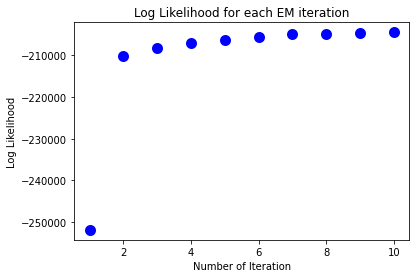

In [22]:
hmm_music = HMM(3, 8, pi, A, B, max_iter = 10)

hmm_music.reestimate(music_feature)

Epoch:  1  Likelihood:  -266999.2060673896
Epoch:  2  Likelihood:  -219026.46345208652
Epoch:  3  Likelihood:  -215029.30886295764
Epoch:  4  Likelihood:  -213195.91574769164
Epoch:  5  Likelihood:  -211856.73712528925
Epoch:  6  Likelihood:  -210157.91140355953
Epoch:  7  Likelihood:  -207758.6772011333
Epoch:  8  Likelihood:  -206115.08044908708
Epoch:  9  Likelihood:  -205467.7364638876
Epoch:  10  Likelihood:  -204957.4311195665


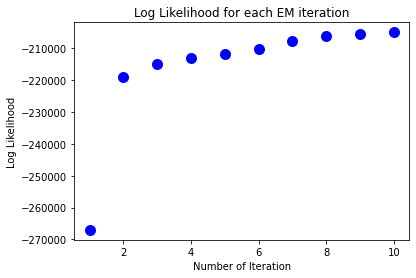

In [23]:
hmm_speech = HMM(3, 8, pi, A, B, max_iter = 10)

hmm_speech.reestimate(speech_feature)

### Yes, the EM algorithm improve the likelihood at each iteration

In [24]:
folders = ['speech_', 'music_']

accuracy = 0

for j in range(2):
    for i in range(1, 24):
        feature = np.zeros((0, 32))
        sample_rate, clean_wav = read_audio('test/', folders[j]+str(i)+'.wav')
        clean_spec = fft(sample_rate, clean_wav)
        
        prob_music = hmm_music.forward_procedure(clean_spec)

        prob_speech = hmm_speech.forward_procedure(clean_spec)
        
        if j == 1 and prob_music >= prob_speech:
            accuracy+=1
        elif j == 0 and prob_music <= prob_speech:
            accuracy+=1
            
print("Accuracy: ", accuracy, accuracy/48 * 100)

Accuracy 39 81.25


### Question 3) d)

## Total Test Accuracy: 81.25 %